### __Loading data + synching them__

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from modules.utils import *
from modules.localization import *

In [30]:
dataset_num = 20 # or 21
dataset_names = {
    "encoder": "Encoders",
    "lidar": "Hokuyo",
    "imu": "Imu",
    "rgbd": "Kinect",
}

data = load_data(dataset_num, dataset_names)
encoder = Encoder(data["encoder"])
lidar = Lidar(data["lidar"])
imu = Imu(data["imu"])
rgbd = Kinect(data["rgbd"])

synchronize_sensors(encoder, imu, lidar, base_sensor_index=0)

In [31]:
lidar.ranges_synced.shape

(4956, 1081)

### __Generate pose estimates using differential-drive motion model__

In [32]:
# Should turn this into a function called pose_from_odom()
# where odometry is generated from imu and encoder measurement.

dt = 1./40.
states = [[0, 0, 0]]
for i in range(1, encoder.counts_synced.shape[0]):
    v = v_from_encoder(encoder.counts_synced[i])
    w = imu.gyro_synced[i]
    state = diff_drive_motion_model(states[-1], v, w, dt)
    states.append(state)
states = np.array(states)

### __Plot robot's trajectory using pose estimates__

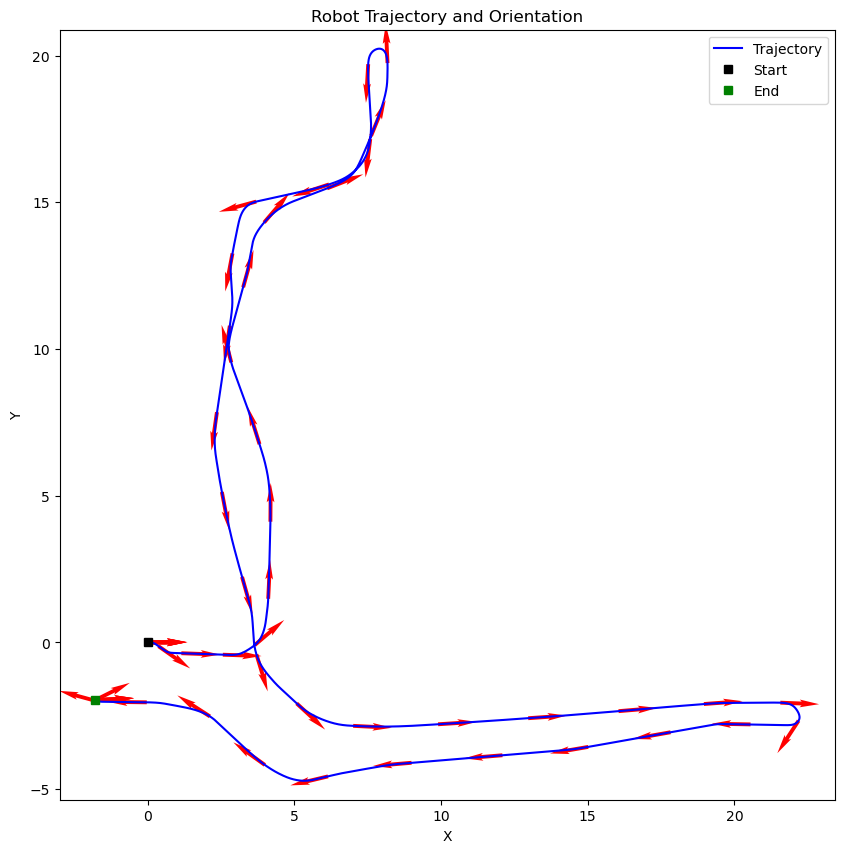

In [33]:
import matplotlib.pyplot as plt

# Extract x, y coordinates and yaw angles
x = states[:, 0]
y = states[:, 1]
yaw = states[:, 2]

# Plot trajectory
plt.figure(figsize=(10, 10))
plt.plot(x, y, label='Trajectory', color='blue')

plt.plot(x[0], y[0], 's', color='black', label='Start')
plt.plot(x[-1], y[-1], 's', color='green', label='End')


# Plot robot's coordinate frame every 100 steps
for i in range(0, len(x), 100):
    # Calculate the end points of the orientation vector, adjusting length here
    dx = np.cos(yaw[i]) * 0.5  # Adjust multiplier to control arrow length
    dy = np.sin(yaw[i]) * 0.5  # Adjust multiplier to control arrow length
    
    # Plot the orientation vector as an arrow
    plt.quiver(x[i], y[i], dx, dy, color='red', scale=10, width=0.005, headwidth=2, headlength=5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Robot Trajectory and Orientation')
plt.legend()
plt.axis('equal')
plt.show()

In [27]:
lidar_ranges, lidar_range_max, lidar_range_min = lidar.ranges_synced, lidar.range_max, lidar.range_min
xy_robot = get_lidar_data(lidar_ranges, lidar_range_min, lidar_range_max)

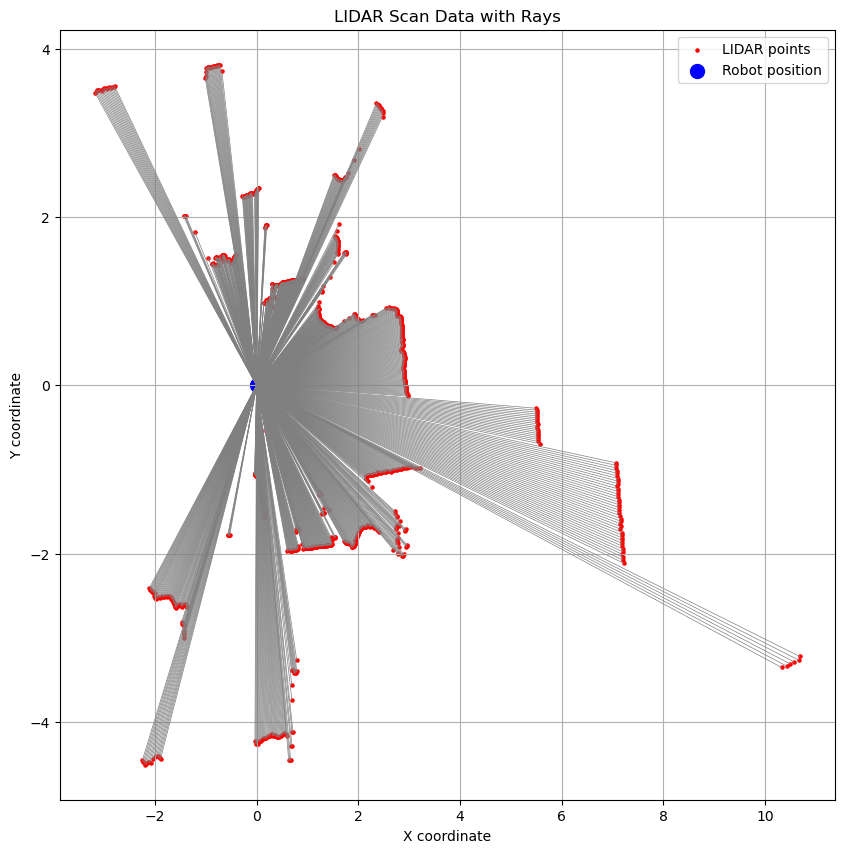

In [45]:
# # Plotting the LIDAR data
# t = 100 # the time step to plot
# x = states[t, 0]
# y = states[t, 1]
# yaw = states[t, 2]

# plt.figure(figsize=(10, 10))
# plt.scatter(xy_world[t][:, 0], xy_world[t][:, 1], s=5, c='red', label='LIDAR points')
# plt.title('LIDAR Scan Data')
# plt.xlabel('X coordinate')
# plt.ylabel('Y coordinate')
# plt.legend()
# plt.grid(True)
# plt.show()

t = 100  # the time step to plot
x = states[t, 0]  # Robot's x position
y = states[t, 1]  # Robot's y position
yaw = states[t, 2]  # Robot's orientation

plt.figure(figsize=(10, 10))
plt.scatter(xy_world[t][:, 0], xy_world[t][:, 1], s=5, c='red', label='LIDAR points')

# Plot rays from the robot to each LIDAR point
for point in xy_world[t]:
    plt.plot([x, point[0]], [y, point[1]], 'gray', linewidth=0.5)  # Use 'gray' for ray color, adjust linewidth as needed

# Plot the robot's position
plt.scatter(x, y, s=100, c='blue', label='Robot position')  # Adjust s for size, c for color

plt.title('LIDAR Scan Data with Rays')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True)
plt.show()